In [1]:
# !python -m pip install -r ../requirements.txt
# !python -m pip install -e ../libs

# What is this notebook for ?

As a pretask to annotate the training data, we will do below tasks
1. Filter the train data split prepared in owlv2_datasetprep_1.ipynb notebook
2. Annotate the images with bounding boxes predicted by owlv2 model
3. Prepare the dataset and upload to roboflow
4. (in roboflow) adjust the bounding boxes and labels.

## Validate the train/val before pre-annotating

In [2]:
from binsense.config import BIN_DATA_DIR
import pandas as pd
import os

file_path = os.path.join(BIN_DATA_DIR, 'train_test_val_split_item.csv')
item_df = pd.read_csv(file_path, dtype={'image_name': str, 'bbox_label': str})
item_df = item_df[["image_name", "tag", "bbox_label", "bbox_count"]]

# filter for train data and get bin_ids
train_item_df = item_df[item_df["tag"] != "test"]
train_bin_df = train_item_df[["image_name", "tag"]].drop_duplicates(ignore_index=True)
print('check(No duplicate bins):', train_bin_df.shape[0] == train_bin_df["image_name"].nunique())

check(No duplicate bins): True


## Pre-annotate the images with the bounding boxes predicted by OWLv2 model
We can use any other model. I found OWLv2 (based on CLIP, trained on social net images) seems to be good enough for now. Haven't tried other models.

2024-05-10 17:54:08,455 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.
2024-05-10 17:54:09,644 INFO : backed up /Users/n0c09jf/code/github/binsense/data/bin/pre-annotate_labels.cpt as /Users/n0c09jf/code/github/binsense/data/bin/pre-annotate_labels.cpt.53.bkp
2024-05-10 17:54:09,645 INFO : backed up /Users/n0c09jf/code/github/binsense/data/bin/pre-annotate_bboxes.cpt as /Users/n0c09jf/code/github/binsense/data/bin/pre-annotate_bboxes.cpt.53.bkp
2024-05-10 17:54:09,730 INFO : predicting bboxes:   0%|          | 0/10 [00:00<?, ?it/s]
2024-05-10 17:54:11,024 INFO : predicting bboxes:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]
2024-05-10 17:54:12,245 INFO : predicting bboxes:  40%|████      | 4/10 [00:02<00:03,  1.60it/s]
2024-05-10 17:54:14,696 INFO : predicting bboxes:  80%|████████  | 8/10 [00:04<00:01,  1.62it/s]


checkpoint at ('/Users/n0c09jf/code/github/binsense/data/bin/pre-annotate_labels.cpt', '/Users/n0c09jf/code/github/binsense/data/bin/pre-annotate_bboxes.cpt')


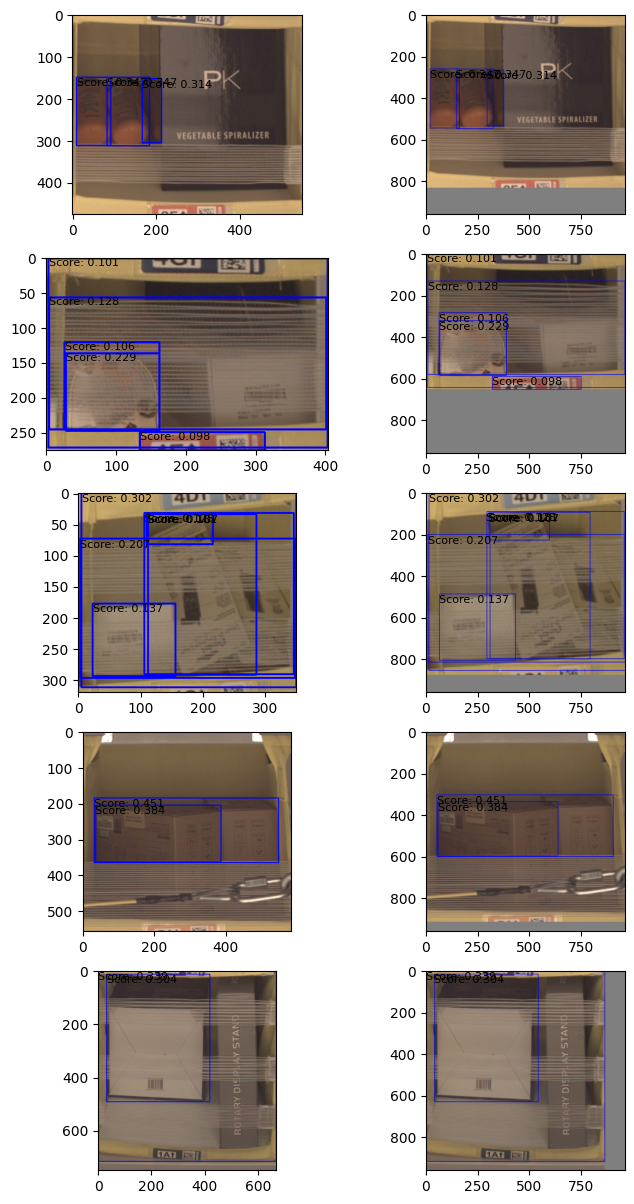

In [3]:
from binsense.cli.owlv2.run_preannotator import run_annotate

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

run_annotate(batch_size=2, test_run=True, device='mps')

## Prepare the folder in Yolov8 format to be uploaded to Roboflow
Roboflow supports only yolov8 format to upload using browser. I tried COCO and VOC formats but I had issues with seeing the annotations after uploading.

In [3]:
from binsense.cli.owlv2.run_preannotator import run_create_dataset

run_create_dataset()

built at /Users/n0c09jf/code/github/binsense/data/bin/robo_upload


## Manually upload the directory prepared on app.roboflow.com
1. Create a object detection project with 'bins' as annotation group
2. Select the project, go to 'Upload Data' selection
3. Drag and drop the folder prepared (above cell)

## Prepare csv file to be sharded with Annotators

In [2]:

from binsense.config import BIN_DATA_DIR
import binsense.dataprep.metadata as m
import os, logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

_, all_item_df = m.load()
all_item_df["image_name"] = all_item_df["bin_id"] + '.jpg'
first_column = all_item_df.pop('image_name') 
all_item_df.insert(0, 'image_name', first_column) 
all_item_df.sort_values(by=["bin_id", "item_id"], inplace=True)
all_item_df.drop(["bin_id"], axis=1, inplace=True)
all_item_df.to_csv(
    os.path.join(BIN_DATA_DIR, 'data_for_annotators.csv'),
    index=False
)

loading bin-metadata: 100%|██████████| 3875/3875 [01:23<00:00, 46.19it/s]
